In [2]:
import numpy as np # scientific computing
import pandas as pd # data loading and processing
import os # os operations
import matplotlib.pyplot as plt # for generating figures
import math
import matplotlib.dates as mdates
import seaborn as sns # for generating visualizations, better support with pandas than matplotlib
from scipy import stats

In [25]:
# get names of nrf2 target genes
nrf2_names = pd.read_csv("./data/nrf2 target genes.csv", index_col=None, header= None).T
nrf2_names = nrf2_names.loc[0].to_list()

In [26]:
ox_stress = pd.read_csv(".data/oxstress genes.csv", index_col=None, header= 0)
ox_stress = ox_stress['Review'].dropna().tolist()

FileNotFoundError: [Errno 2] No such file or directory: '.data/oxstress genes.csv'

In [24]:
targets = list(set(["G6PD", "RRM2B"] +  nrf2_names + ox_stress))


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_6929/4220548363.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nrf2["NFE2L2"] = nrf2.mean(axis = 1)


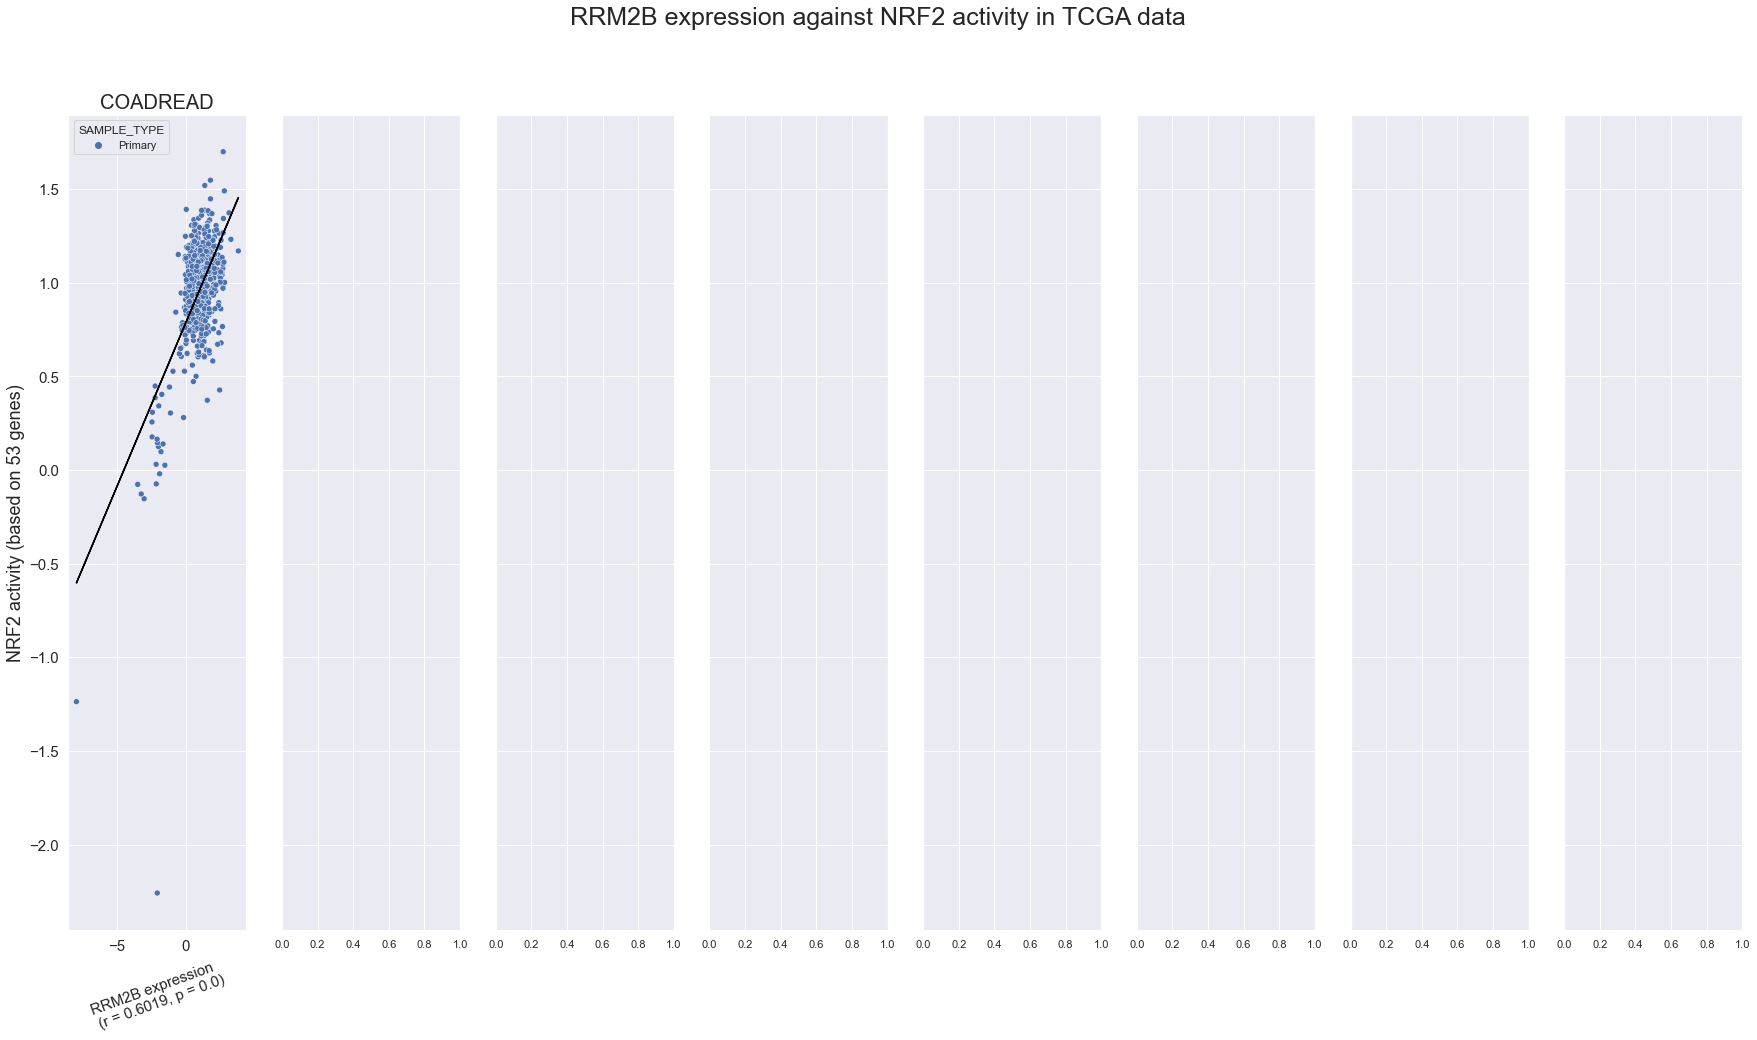

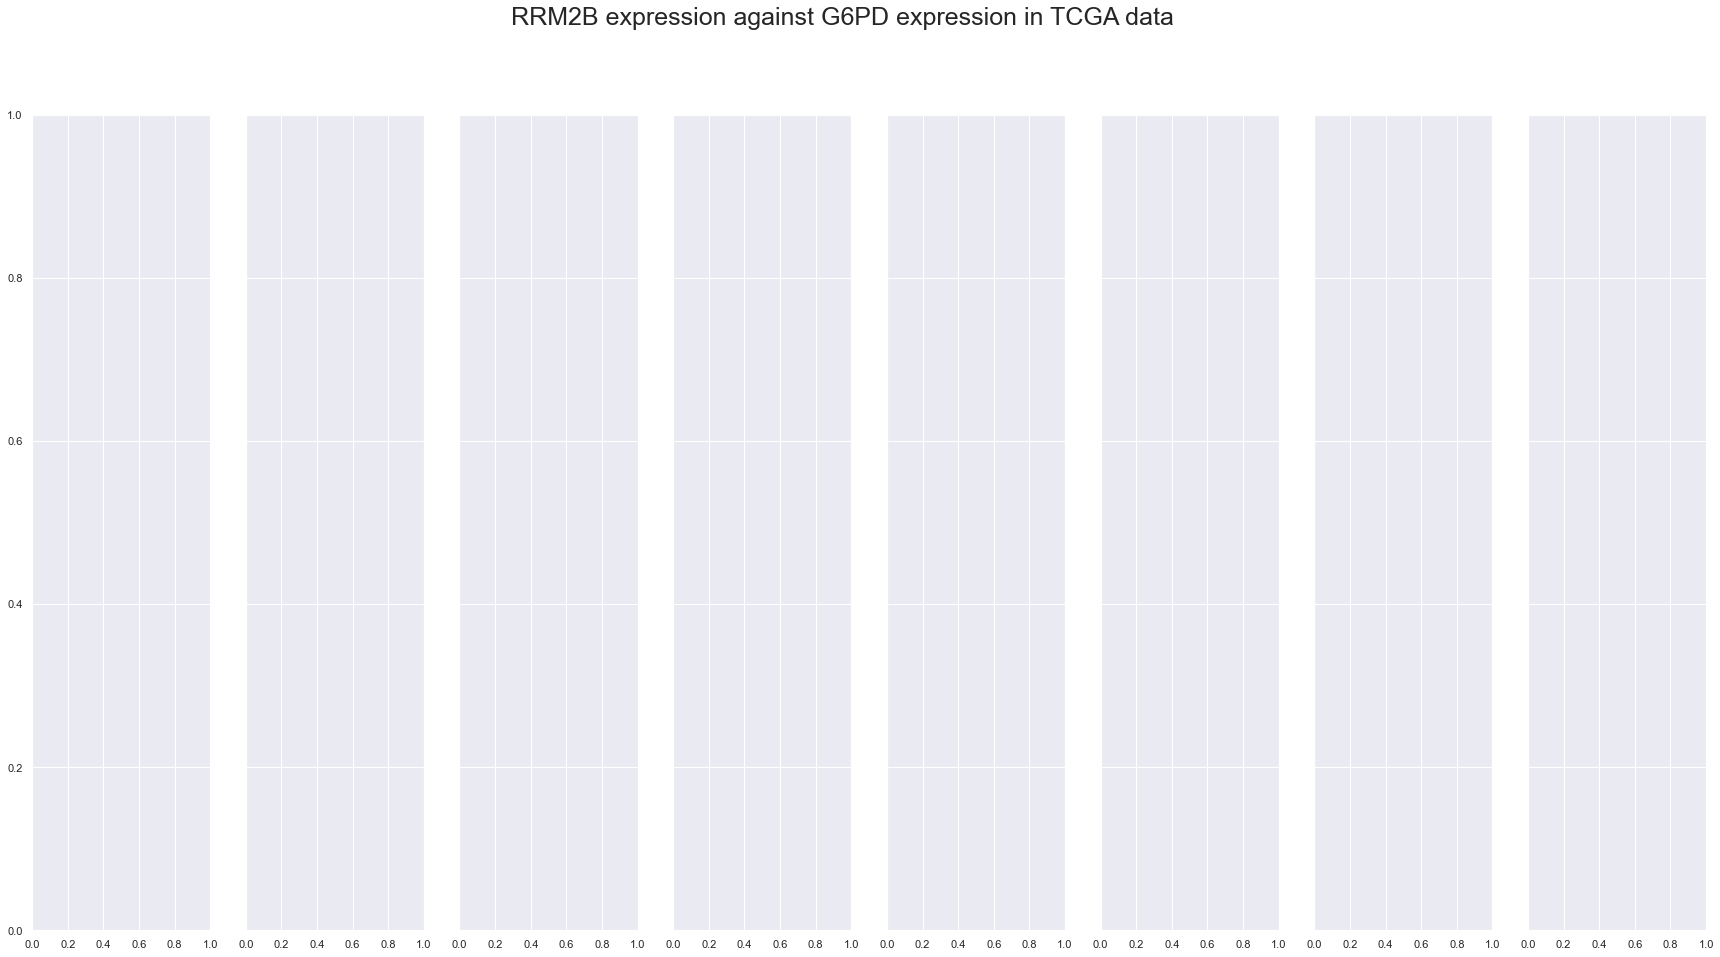

Ttest_indResult(statistic=6.873196028907047, pvalue=3.780667279465968e-11)


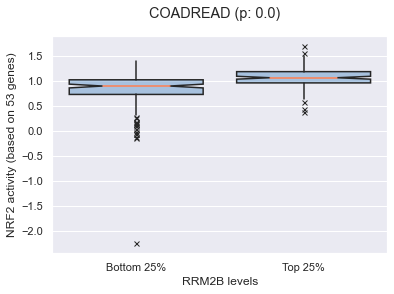

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_6929/4220548363.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nrf2["NFE2L2"] = nrf2.mean(axis = 1)


Ttest_indResult(statistic=0.7145306475722597, pvalue=0.4755526984362105)


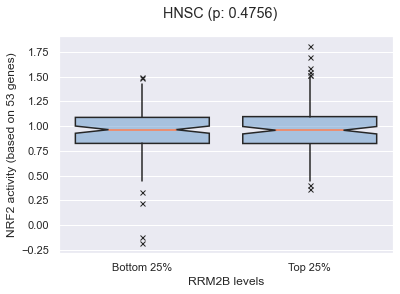

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_6929/4220548363.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nrf2["NFE2L2"] = nrf2.mean(axis = 1)


Ttest_indResult(statistic=4.863382393446648, pvalue=2.0294310939513544e-06)


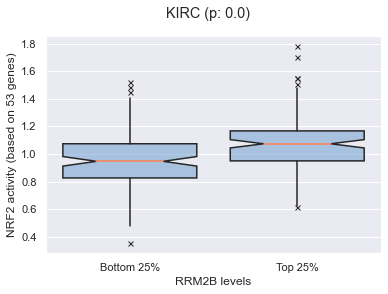

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_6929/4220548363.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nrf2["NFE2L2"] = nrf2.mean(axis = 1)


Ttest_indResult(statistic=1.1597360128344298, pvalue=0.2472496002939923)


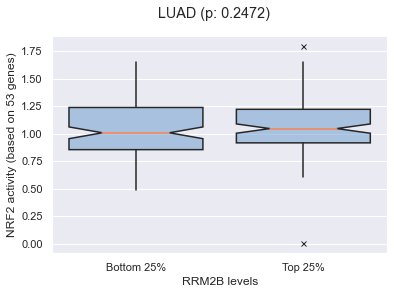

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_6929/4220548363.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nrf2["NFE2L2"] = nrf2.mean(axis = 1)


Ttest_indResult(statistic=4.990712980048058, pvalue=1.4060333320528982e-06)


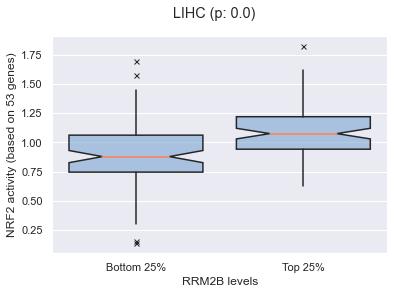

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_6929/4220548363.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nrf2["NFE2L2"] = nrf2.mean(axis = 1)


Ttest_indResult(statistic=1.0283862528740635, pvalue=0.30480780912007266)


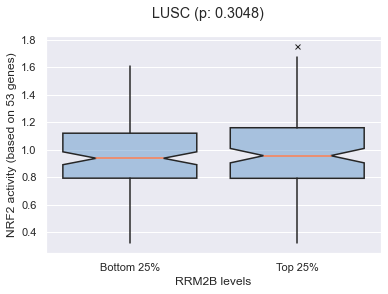

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_6929/4220548363.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nrf2["NFE2L2"] = nrf2.mean(axis = 1)


Ttest_indResult(statistic=-1.6709195109567443, pvalue=0.09686523902877683)


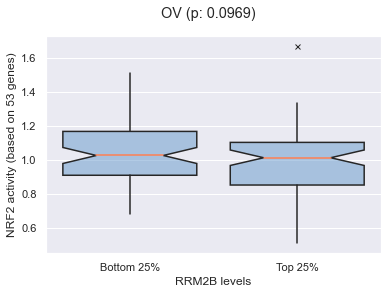

/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_6929/4220548363.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nrf2["NFE2L2"] = nrf2.mean(axis = 1)


Ttest_indResult(statistic=7.4551942199782415, pvalue=3.602785945796333e-13)


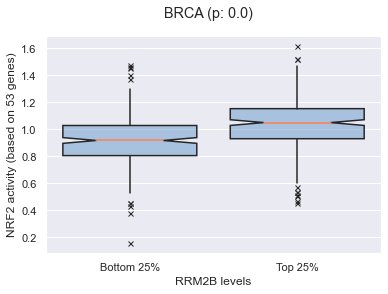

In [16]:
rval1 =[]
rval2 = []
cancer = ["COADREAD", "HNSC", "KIRC", "LUAD", "LIHC", "LUSC", "OV", "BRCA"] # , , "PANCAN"

fig, axs = plt.subplots(1, len(cancer), figsize=(30, 15), sharey=True)
fig.suptitle('RRM2B expression against NRF2 activity in TCGA data',fontsize = 25)

fig1, axs1 = plt.subplots(1, len(cancer), figsize=(30, 15), sharey=True)
fig1.suptitle('RRM2B expression against G6PD expression in TCGA data',fontsize = 25)

for c in cancer:
    # construct the file name
    # n1 = "TCGA." + c + ".sampleMap_HiSeqV2"
    n1 = "./data/" + c+"_data_mrna_seq_v2_rsem.txt"
    # n2 = "TCGA." + c + ".sampleMap_"+ c +"_clinicalMatrix"
    n2 = "./data/" + c + "_data_clinical_sample.txt"

    # get expression data
    df = pd.read_csv(n1, index_col = 0, sep = "\t").drop(["Entrez_Gene_Id"], axis=1) # gene x patient

    # get phenotypes of samples
    pheno = pd.read_csv(n2, index_col=1,header = 4, sep = "\t")
    pheno = pheno[["SAMPLE_TYPE"]]
    pheno_filtered = pheno.dropna()

    # subset to get relevant genes
    df_filtered = df.loc[nrf2_names + ["RRM2B"]]
    df_filtered.dropna(inplace=True, axis = 1)
    df_filtered = df_filtered.T # patients x genes

    # scale numerical data
    df_filtered = np.log10(df_filtered+1)

    # for each sequenced gene were rescaled to set the median equal to 1
    df_filtered=((df_filtered-df_filtered.median())/df_filtered.std())+1

    # filter for only cancer samples
    data = pd.concat([df_filtered, pheno_filtered], axis = 1, join='inner')

    # # transpose to patient x gene
    # df2 = df2.T  

    # # drop normal samples
    # df2.drop(df2.loc[df2["sample_type"] == "Solid Tissue Normal"].index, inplace=True)

    # # drop sample type column
    # data = df2.drop("sample_type", axis = 1)

    # # convert data to float
    # data = data.astype("float64")

    # take only nrf2 target genes
    nrf2 = data[nrf2_names]
    data.drop(nrf2_names, inplace = True, axis = 1)
    nrf2["NFE2L2"] = nrf2.mean(axis = 1)
    data = pd.concat([data, nrf2], axis = 1) # patients x genes 
    
    #find line of best fit
    y, x = data["NFE2L2"].to_numpy(), data["RRM2B"].to_numpy()
    a, b = np.polyfit(x, y, 1)

    iqr = data["RRM2B"].T.describe()

    # bin the patients into quartiles based on G6PD expression
    data["RRM2B levels"] = pd.cut(data["RRM2B"],
                    bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                    labels=["Bottom 25%", "-", "Top 25%"])

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]
    rval1.append(r)


    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2

    # plot the data

    # scatter plot for RRM2B against NRF2 activity
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x="RRM2B", y="NFE2L2", hue= "SAMPLE_TYPE", ax= axs[cancer.index(c)])
    axs[cancer.index(c)].plot(x, a*x+b, color="black")
    axs[cancer.index(c)].set_ylabel("NRF2 activity (based on 53 genes)",fontsize = 18)
    axs[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=20,fontsize = 15)
    axs[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    axs[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    plt.show()

    # save the figure 
    fig.savefig("TCGA colorectal cancer data.png")

    #find line of best fit for G6PD against RRM2B
    y, x = data["G6PD"].to_numpy(), data["RRM2B"].to_numpy()
    a, b = np.polyfit(x, y, 1)

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]
    rval2.append(r)

    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2

    # scatter plot for G6PD against RRM2B
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x="RRM2B", y="G6PD", hue= "SAMPLE_TYPE", ax= axs1[cancer.index(c)])
    axs1[cancer.index(c)].plot(x, a*x+b, color="black")
    axs1[cancer.index(c)].set_ylabel("G6PD expression",fontsize = 18)
    axs1[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=20,fontsize = 15)
    axs1[cancer.index(c)].set_title(cancer[cancer.index(c)], fontsize = 20)
    axs1[cancer.index(c)].tick_params(axis='both', which='major', labelsize=15)
    plt.show()

    # save the figure
    fig1.savefig("RRM2B vs G6PD.png")

    # filter top and botton 25% of patients
    data["RRM2B levels"] = data["RRM2B levels"].cat.remove_categories("-")
    top = data[data["RRM2B levels"] == "Top 25%"]["NFE2L2"]
    bottom = data[data["RRM2B levels"] == "Bottom 25%"]["NFE2L2"]

    out = stats.ttest_ind(top, bottom)
    print(out)
 
    # box plot
    fig2, axs2 = plt.subplots()
    fig2.suptitle(c + " (p: " + str(round(out.pvalue,4)) + ")")
    sns.set_style("whitegrid")
    sns.set()
    sns.boxplot(data=data, x="RRM2B levels", y="NFE2L2", color="green", ax= axs2, notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"})
    axs2.set_ylabel("NRF2 activity (based on 53 genes)")
    # axs[cancer.index(c)].set_xlabel("RRM2B expression" + " \n (r = " + str(round(r, 4)) + "," + " p = " + str(round(p, 4)) +")",rotation=20,fontsize = 15)
    plt.show()

    # save the figure
    fig2.savefig(c+"boxplot.png")






In [ ]:
out.pvalue

In [ ]:
# Import Library
import scipy.stats
  
# To find the T critical value
scipy.stats.t.ppf(q=0.05,df=34)

In [ ]:
rval

In [12]:
data

,RRM2B,SAMPLE_TYPE,ABCC5,ADD3,APIP,ASF1A,AXIN2,BMP4,CAP2,CAT,...,PRRT1,PTGR1,SH3RF2,SRP9,SUB1,TBC1D14,TSEN2,TXNRD1,G6PD,NFE2L2
TCGA-3L-AA1B-01,0.618978,NaN,1.714744,1.767750,1.546140,0.125286,2.565266,2.188946,0.964729,-0.022255,...,2.155466,1.352867,1.381721,0.612962,0.655528,2.183727,1.303027,0.735569,0.920074,1.077321
TCGA-4N-A93T-01,-0.023717,NaN,3.305797,1.164494,3.350033,0.509658,0.492276,-0.947278,1.828318,0.615727,...,2.332092,1.091824,3.328564,0.665061,0.886289,0.662241,2.464223,1.660784,0.752126,0.731143
TCGA-4T-AA8H-01,0.956650,NaN,3.185565,0.321230,3.312198,-0.002652,1.559603,1.077893,-0.698497,1.470156,...,2.150419,-0.028925,2.086020,0.622094,0.271091,1.129440,1.955488,1.124943,0.875730,0.783638
TCGA-5M-AAT4-01,0.758726,NaN,2.352663,0.373670,1.907423,0.796535,0.592824,0.374124,-0.241986,-0.564350,...,1.203934,0.838350,0.712374,0.104455,1.448887,2.231602,2.671679,0.439151,2.267472,0.822956
TCGA-5M-AAT5-01,0.067943,NaN,1.675476,0.269196,2.013284,0.732234,1.454390,-0.166552,-0.225909,1.249347,...,0.163698,0.500376,2.186128,0.756255,-0.584246,1.506989,2.916013,1.586168,0.984595,0.944701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-SS-A7HO,NaN,Primary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-T9-A92H,NaN,Primary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-WS-AB45,NaN,Primary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-5M-AAT5,NaN,Primary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
sum(data2["RRM2B levels"] == "-")